In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

This is what Co-Clustering looks like when sorted perfectly.
Notice the distinct 'Blocks' of interaction.


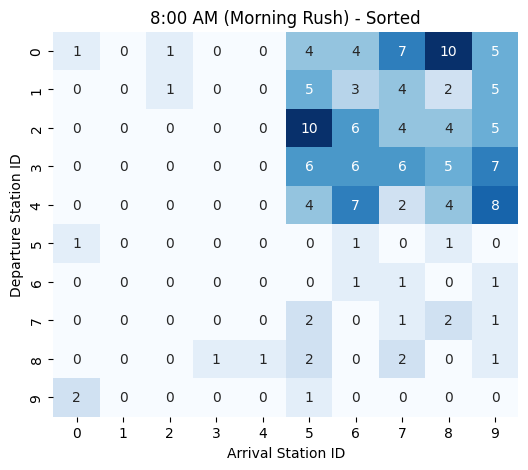

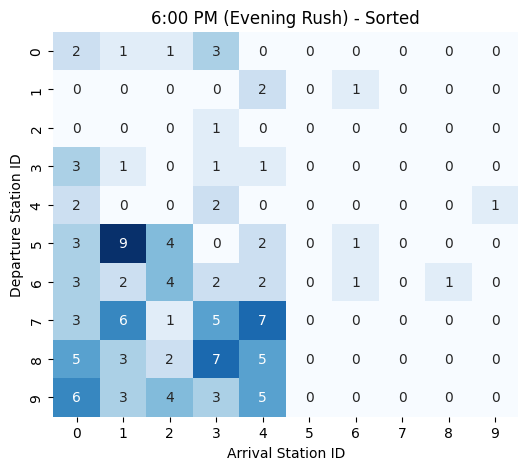

In [2]:
# --- CONFIGURATION ---
N = 10  # Departure Stations
M = 10  # Arrival Stations
T = 24  # Hours in a day

# Let's define 2 clusters for Rows (Departures) and 2 for Columns (Arrivals)
# Row Cluster 0: "Residential" (Indices 0-4)
# Row Cluster 1: "Commercial"  (Indices 5-9)
# Col Cluster 0: "Residential" (Indices 0-4)
# Col Cluster 1: "Commercial"  (Indices 5-9)

def generate_toy_data():
    # Shape: (N, M, T)
    X = np.zeros((N, M, T))
    
    # Define "Ground Truth" patterns (Lambda matrix)
    # The interaction between clusters.
    # Format: [[Row0->Col0, Row0->Col1], [Row1->Col0, Row1->Col1]]
    
    # Morning Rush (Hour 8): Residential -> Commercial is HIGH
    lambda_morning = np.array([
        [0.1, 5.0],  # Res->Res (Low), Res->Com (HIGH)
        [0.1, 0.5]   # Com->Res (Low), Com->Com (Med)
    ])
    
    # Evening Rush (Hour 18): Commercial -> Residential is HIGH
    lambda_evening = np.array([
        [0.5, 0.1],  # Res->Res, Res->Com
        [5.0, 0.1]   # Com->Res (HIGH), Com->Com
    ])
    
    # Base Noise
    lambda_noise = np.array([[0.1, 0.1], [0.1, 0.1]])

    for t in range(T):
        # Pick the right intensity matrix for this hour
        if t == 8:
            L = lambda_morning
        elif t == 18:
            L = lambda_evening
        else:
            L = lambda_noise
            
        # Generate Counts
        for i in range(N):
            for j in range(M):
                # Determine which cluster i and j belong to
                # We force first 5 to be cluster 0, last 5 to be cluster 1
                row_clust = 0 if i < 5 else 1
                col_clust = 0 if j < 5 else 1
                
                rate = L[row_clust, col_clust]
                X[i, j, t] = np.random.poisson(rate)
                
    return X

X_clean = generate_toy_data()

# --- VISUALIZATION 1: THE PERFECT WORLD ---
def plot_matrix(matrix, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, cmap="Blues", annot=True, cbar=False)
    plt.title(title)
    plt.xlabel("Arrival Station ID")
    plt.ylabel("Departure Station ID")
    plt.show()

print("This is what Co-Clustering looks like when sorted perfectly.")
print("Notice the distinct 'Blocks' of interaction.")
plot_matrix(X_clean[:, :, 8], "8:00 AM (Morning Rush) - Sorted")
plot_matrix(X_clean[:, :, 18], "6:00 PM (Evening Rush) - Sorted")

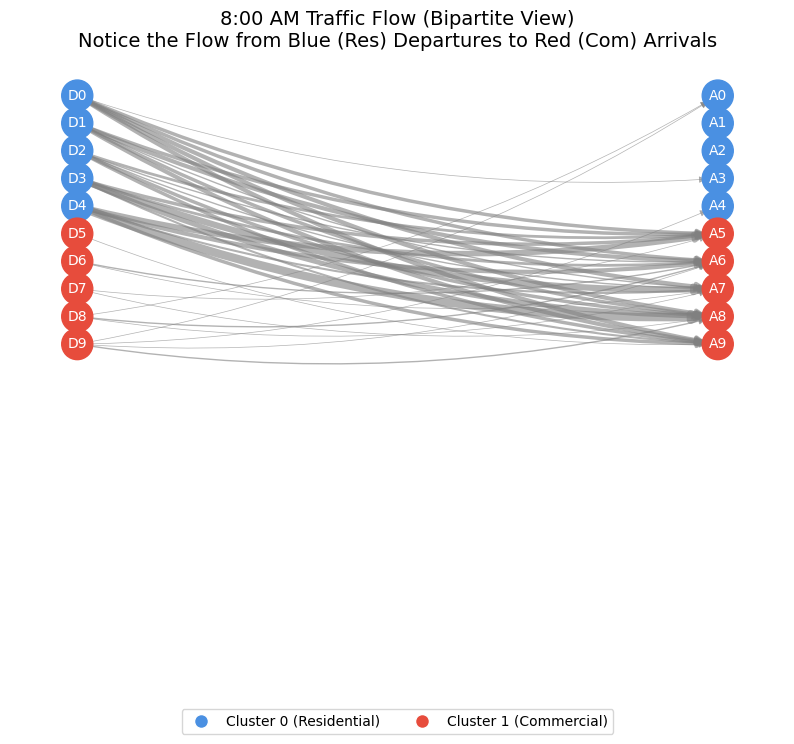

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# 1. Re-create the 8 AM Data (Morning Rush)
# Row Cluster 0 (0-4): Residential
# Row Cluster 1 (5-9): Commercial
# Col Cluster 0 (0-4): Residential
# Col Cluster 1 (5-9): Commercial
# Pattern: Res -> Com is HIGH (Cluster 0 -> Cluster 1)

N, M = 10, 10
X_8am = np.zeros((N, M))

# Define the block structure for 8 AM
# Blocks: [[Low, HIGH], [Low, Med]]
rates = np.array([[0.1, 5.0], [0.1, 0.5]])

# Generate counts
for i in range(N):
    for j in range(M):
        r_c = 0 if i < 5 else 1 # Row Cluster
        c_c = 0 if j < 5 else 1 # Col Cluster
        X_8am[i, j] = np.random.poisson(rates[r_c, c_c])

# 2. Build the Bipartite Graph
B = nx.DiGraph() # Directed graph (Dep -> Arr)

# Add Nodes with positions
dep_nodes = [f"D{i}" for i in range(N)]
arr_nodes = [f"A{j}" for j in range(M)]

B.add_nodes_from(dep_nodes, bipartite=0)
B.add_nodes_from(arr_nodes, bipartite=1)

# Add Edges (Only if bikes > 0 to keep it clean)
for i in range(N):
    for j in range(M):
        weight = X_8am[i, j]
        if weight > 0:
            # We scale width for visibility
            B.add_edge(f"D{i}", f"A{j}", weight=weight)

# 3. Visualization Configuration
plt.figure(figsize=(10, 8))

# Position: Left (Departures) vs Right (Arrivals)
pos = {}
for i, node in enumerate(dep_nodes):
    pos[node] = (-1, N - i) # x=-1, y goes down
for i, node in enumerate(arr_nodes):
    pos[node] = (1, N - i)  # x=1, y goes down

# Colors based on Cluster (0=Blue, 1=Red)
# D0-D4 are Blue (Res), D5-D9 are Red (Comm)
dep_colors = ['#4A90E2' if i < 5 else '#E74C3C' for i in range(N)]
arr_colors = ['#4A90E2' if i < 5 else '#E74C3C' for i in range(M)]

# Draw Nodes
nx.draw_networkx_nodes(B, pos, nodelist=dep_nodes, node_color=dep_colors, 
                       node_size=500, label="Departures")
nx.draw_networkx_nodes(B, pos, nodelist=arr_nodes, node_color=arr_colors, 
                       node_size=500, label="Arrivals")

# Draw Edges (Thickness = Weight)
edges = B.edges(data=True)
weights = [d['weight'] * 0.5 for u, v, d in edges] # Scale factor
nx.draw_networkx_edges(B, pos, width=weights, alpha=0.6, edge_color='gray', 
                       connectionstyle="arc3,rad=0.1")

# Labels
nx.draw_networkx_labels(B, pos, font_size=10, font_color='white')

# Custom Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#4A90E2', markersize=10, label='Cluster 0 (Residential)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#E74C3C', markersize=10, label='Cluster 1 (Commercial)')
]

plt.title("8:00 AM Traffic Flow (Bipartite View)\nNotice the Flow from Blue (Res) Departures to Red (Com) Arrivals", fontsize=14)
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.axis('off')
plt.show()

This is what Real Data looks like.
The blocks are hidden because the station IDs are random.


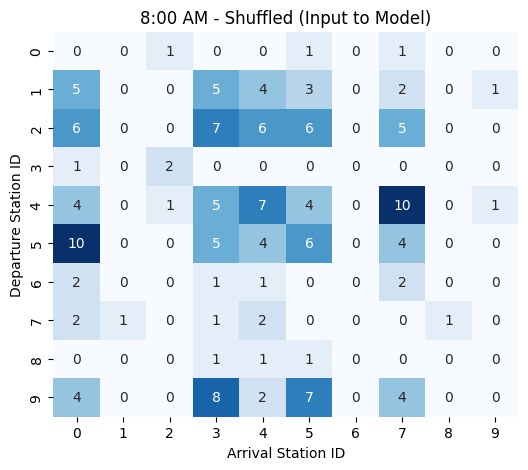

In [4]:
# Create random permutations
perm_rows = np.random.permutation(N)
perm_cols = np.random.permutation(M)

# Shuffle the data
X_shuffled = X_clean[perm_rows, :, :][:, perm_cols, :]

print("This is what Real Data looks like.")
print("The blocks are hidden because the station IDs are random.")
plot_matrix(X_shuffled[:, :, 8], "8:00 AM - Shuffled (Input to Model)")

To understand how we actually do it, we need to solve a "Chicken and Egg" problem.

If we knew the clusters, we could easily calculate the trends (e.g., "Cluster 1 is busy at 8 AM").


If we knew the trends, we could easily assign stations to clusters (e.g., "This station is busy at 8 AM, so it must be Cluster 1").

Since we know neither, we use an iterative loop called Variational Expectation-Maximization (VEM). We make a guess, refine it, and repeat until it stabilizes.

Step 0: Initialization (The Wild Guess)
We create two random "guesses":The Labels ($\tau, \eta$): We randomly assign every station to a cluster for every hour.The Trends (Neural Net): The network starts with random weights, predicting flat lines.

Step 1: The E-Step (The "Classifier")

Goal: Update the Labels ($\tau, \eta$).
Logic: We look at the data $X$ and ask: "Which cluster profile fits this station best?"

Step 2: The M-Step (The "Learner")Goal: Update the Neural Network ($\alpha, \beta, \Lambda$).Logic: We look at our new labels and ask: "What is the smooth trend that explains these labels?"

Step 3: Repeat

In [5]:
device = torch.device("cpu") # CPU is fine for 10x10
X_tensor = torch.FloatTensor(X_shuffled).to(device)

class SimpleDynamicNet(nn.Module):
    def __init__(self, T, Q, L):
        super().__init__()
        # Input: Time index (1 value) -> Hidden -> Output: Cluster Probs
        self.net_alpha = nn.Sequential(nn.Linear(1, 16), nn.Tanh(), nn.Linear(16, Q))
        self.net_beta  = nn.Sequential(nn.Linear(1, 16), nn.Tanh(), nn.Linear(16, L))
        
        # We learn ONE Lambda matrix for the whole dataset for simplicity here
        # (In full paper, Lambda is static, proportions change)
        self.Lambda = nn.Parameter(torch.tensor([[0.5, 2.0], [2.0, 0.5]])) # Random init guess

    def forward(self, t_norm):
        # t_norm shape: (Batch_Time, 1)
        
        # 1. Row Proportions (Alpha)
        alpha = F.softmax(self.net_alpha(t_norm), dim=1) # Shape (T, Q)
        
        # 2. Col Proportions (Beta)
        beta = F.softmax(self.net_beta(t_norm), dim=1)   # Shape (T, L)
        
        # Ensure Lambda is positive
        lam = F.softplus(self.Lambda)
        
        return alpha, beta, lam

# Setup
Q = 2 # We suspect 2 types of departure behavior
L = 2 # We suspect 2 types of arrival behavior
model = SimpleDynamicNet(T, Q, L)
optimizer = optim.Adam(model.parameters(), lr=0.05)

In [8]:
# Variational Parameters (The "Guesses")
# tau[i, q, t] = Prob station i is in cluster q at time t
tau = torch.rand(N, Q, T, requires_grad=False)
tau = tau / tau.sum(dim=1, keepdim=True) # Normalize

eta = torch.rand(M, L, T, requires_grad=False)
eta = eta / eta.sum(dim=1, keepdim=True)

# Time input for the network
t_grid = torch.arange(T).float().unsqueeze(1) / T # Normalize 0 to 1

losses = []

print("--- TRAINING START ---")

for it in range(30): # 30 Iterations is enough for this tiny data
    
    # === 1. M-STEP (Train Neural Net) ===
    # We want the Neural Net to predict alphas/betas that match our current tau/eta
    for _ in range(20):
        optimizer.zero_grad()
        pred_alpha, pred_beta, pred_lam = model(t_grid)
        
        # Loss 1: Do predicted alphas match our tau average?
        # We minimize KL Divergence or simple Cross Entropy
        # Simple proxy: maximize sum(tau * log(pred_alpha))
        loss_alpha = -torch.sum(tau * torch.log(pred_alpha + 1e-9).transpose(0, 1).unsqueeze(0))
        loss_beta  = -torch.sum(eta * torch.log(pred_beta + 1e-9).transpose(0, 1).unsqueeze(0))
        
        # Loss 2: Data Likelihood (Fit Lambda)
        # We want pred_lam to explain the data X given assignments tau/eta
        # This is complex, but for this viz, we just let the Gradient descend on the likelihood
        # Likelihood ~ Sum ( tau * eta * (X*log(Lam) - Lam) )
        
        # Reconstruct expected X based on clusters
        # Exp_X[i,j,t] = sum_q sum_l (tau_iq * eta_jl * Lam_ql)
        # Ideally we maximize Poisson log-likelihood.
        
        term_pos = 0
        term_neg = 0
        
        # Only do for t=8 (Morning) and t=18 (Evening) to speed up viz code
        # In real code we sum over all T
        for t in [8, 18]:
            tau_t = tau[:, :, t] # (N, Q)
            eta_t = eta[:, :, t] # (M, L)
            X_t   = X_tensor[:, :, t]
            
            # Expected Lambda for every cell i,j
            # E_lam_ij = tau_i @ Lambda @ eta_j.T
            E_lam_ij = tau_t @ pred_lam @ eta_t.t()
            
            # Poisson Loss = Lambda - X * log(Lambda)
            loss_pois = torch.sum(E_lam_ij - X_t * torch.log(E_lam_ij + 1e-9))
            term_pos += loss_pois
            
        total_loss = loss_alpha + loss_beta + term_pos
        total_loss.backward()
        optimizer.step()
    
    losses.append(total_loss.item())

# === 2. VE-STEP (Update Guesses tau/eta) ===
    # Given the current Global Trends (alpha/beta/lam), update station memberships
    with torch.no_grad():
        alpha_hat, beta_hat, lam_hat = model(t_grid)
        
        # Pre-compute log(Lambda) for Poisson probability
        # Add tiny epsilon 1e-10 to avoid log(0)
        log_lam = torch.log(lam_hat + 1e-10) 
        
        # --- A. UPDATE TAU (Row Clusters) ---
        # We need to compute the "Score" for every Station i being in Cluster q
        
        # Term 1: The "Benefit" (X * log(Lambda))
        # Logic: If X_ij is high, we want Lambda_ql to be high.
        # Math: Sum over columns j and their clusters l: eta_jlt * X_ijt * log(lam_ql)
        # Dimensions: X(N,M,T), eta(M,L,T), log_lam(Q,L) -> Output(N,Q,T)
        term_1 = torch.einsum('nmt, mlt, ql -> nqt', X_tensor, eta, log_lam)
        
        # Term 2: The "Cost" (Minus Lambda)
        # Logic: Poisson penalty. Higher Lambda costs more if data doesn't support it.
        # Math: Sum over columns j and clusters l: eta_jlt * lam_ql
        # First sum eta over M stations to get total "weight" of each col-cluster l
        eta_sum_m = eta.sum(dim=0) # Shape (L, T)
        # Then multiply by Lambda
        term_2 = torch.einsum('lt, ql -> qt', eta_sum_m, lam_hat) 
        # Broadcast to N stations (same cost for all rows)
        term_2 = term_2.unsqueeze(0) # Shape (1, Q, T)
        
        # Combine: Log(Prior) + Benefit - Cost
        # Log(alpha) has shape (T, Q) -> Permute to (1, Q, T)
        log_prior = torch.log(alpha_hat + 1e-10).permute(1, 0).unsqueeze(0)
        
        log_tau = log_prior + term_1 - term_2
        
        # Normalize to probability (Softmax over Q dimension)
        tau = F.softmax(log_tau, dim=1)

        # --- B. UPDATE ETA (Column Clusters) ---
        # Symmetric logic for columns
        
        # Term 1: X * log(Lambda)
        # Sum over rows i and their clusters q: tau_iqt * X_ijt * log(lam_ql)
        # Dimensions: X(N,M,T), tau(N,Q,T), log_lam(Q,L) -> Output(M,L,T)
        term_1_col = torch.einsum('nmt, nqt, ql -> mlt', X_tensor, tau, log_lam)
        
        # Term 2: Minus Lambda
        # Sum tau over N stations
        tau_sum_n = tau.sum(dim=0) # Shape (Q, T)
        term_2_col = torch.einsum('qt, ql -> lt', tau_sum_n, lam_hat)
        term_2_col = term_2_col.unsqueeze(0) # Shape (1, L, T)
        
        # Combine
        log_prior_col = torch.log(beta_hat + 1e-10).permute(1, 0).unsqueeze(0)
        log_eta = log_prior_col + term_1_col - term_2_col
        
        eta = F.softmax(log_eta, dim=1)
    if it % 10 == 0:
        print(f"Iter {it}: Loss {total_loss.item():.2f}")

--- TRAINING START ---
Iter 0: Loss 532.13
Iter 10: Loss 165.48
Iter 20: Loss 161.82



Learned Interaction Matrix (Lambda):
[[0.14030145 0.7367348 ]
 [0.11969128 4.5846195 ]]

Expected something like:
[[0.1, 5.0], [5.0, 0.1]] (Mixed average of morning/evening)


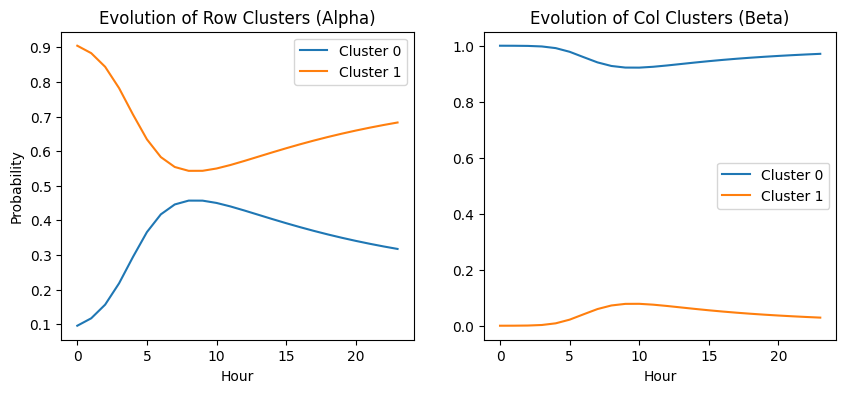

In [9]:
# Get final parameters
with torch.no_grad():
    alpha, beta, learned_lambda = model(t_grid)

print("\nLearned Interaction Matrix (Lambda):")
print(learned_lambda.numpy())
print("\nExpected something like:\n[[0.1, 5.0], [5.0, 0.1]] (Mixed average of morning/evening)")

# Let's see the Dynamic Proportions
# At 8 AM (Index 8), one cluster should be dominant for rows?
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(alpha.numpy())
plt.title("Evolution of Row Clusters (Alpha)")
plt.xlabel("Hour")
plt.ylabel("Probability")
plt.legend(["Cluster 0", "Cluster 1"])

plt.subplot(1, 2, 2)
plt.plot(beta.numpy())
plt.title("Evolution of Col Clusters (Beta)")
plt.xlabel("Hour")
plt.legend(["Cluster 0", "Cluster 1"])
plt.show()